In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window

def create_paint_df_ind_compressed(df, ind, mapping, ns_map):
    d = {}
    max_pos = int(df.epos.iloc[-1])
    df = df.loc[df[ind].shift() != df[ind]].reset_index()
    df["epos"] = pd.concat([df.spos.iloc[1:], pd.Series(max_pos)], ignore_index=True)
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [2]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Kindae, Zambia': 0,
 'Papio, Senegal': 1,
 'Ursinus, Zambia': 0}

In [3]:
df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


<Axes: xlabel='length', ylabel='Count'>

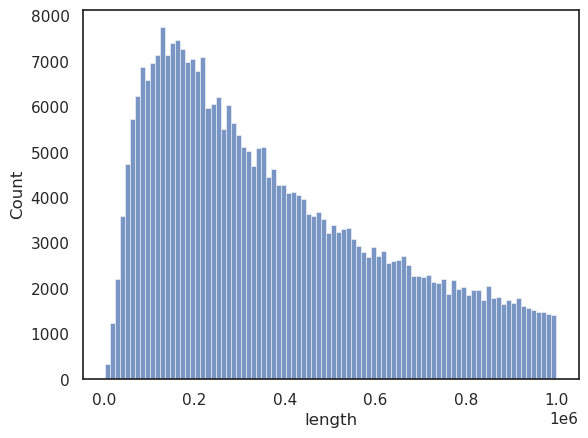

In [4]:
sns.histplot(data=length_df.loc[length_df.length <= 1000000], x="length")

In [5]:
length_df.length.median()

588490.0

In [6]:
length_df["Origin"] = length_df.individual.map(dict(zip(meta_data_samples.PGDP_ID, meta_data_samples.Origin)))
length_df

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,Origin
0,160,9915383,9915224,"Kindae, Zambia",0,Sci_16066,0,chr1,"Mikumi, Tanzania"
1,9915384,10291147,375764,"Hamadryas, Ethiopia",1,Sci_16066,0,chr1,"Mikumi, Tanzania"
2,10291148,33224041,22932894,"Kindae, Zambia",0,Sci_16066,0,chr1,"Mikumi, Tanzania"
3,33224042,33578534,354493,"Hamadryas, Ethiopia",1,Sci_16066,0,chr1,"Mikumi, Tanzania"
4,33578535,39239117,5660583,"Kindae, Zambia",0,Sci_16066,0,chr1,"Mikumi, Tanzania"
...,...,...,...,...,...,...,...,...,...
36,132084938,134178575,2093638,"Kindae, Zambia",0,PD_0774,1,female_chrX,"Mikumi, Tanzania"
37,134178576,141491629,7313054,"Ursinus, Zambia",0,PD_0774,1,female_chrX,"Mikumi, Tanzania"
38,141491630,141642617,150988,"Papio, Senegal",1,PD_0774,1,female_chrX,"Mikumi, Tanzania"
39,141642618,142762281,1119664,"Ursinus, Zambia",0,PD_0774,1,female_chrX,"Mikumi, Tanzania"


In [7]:
mean_origin = length_df.groupby(["chrom", "Origin", "pos"])[["n/s"]].mean().reset_index()

In [8]:
mean_origin_chrx = mean_origin.loc[mean_origin.chrom == "all_chrX"]

In [9]:
mean_focal = mean_origin.loc[mean_origin.Origin == "Serengeti, Tanzania"]
for o in mean_origin.Origin.unique():
    o_div = mean_origin.loc[mean_origin.Origin == o]
    o_div = o_div.merge(mean_focal, on=["chrom", "pos"])
    print(o, stats.spearmanr(o_div["n/s_x"], o_div["n/s_y"]))

Aberdare, Kenya SignificanceResult(statistic=0.3564742704407234, pvalue=6.939987324005455e-67)
Arusha, Tanzania SignificanceResult(statistic=0.49124542012498873, pvalue=2.911574263362893e-242)
Gog Woreda, Gambella region, Ethiopia SignificanceResult(statistic=0.2749605206403949, pvalue=3.167050998151707e-68)
Gombe, Tanzania SignificanceResult(statistic=0.42643369144624815, pvalue=1.0252702020535057e-307)
Issa Valley, Tanzania SignificanceResult(statistic=0.14435017920650717, pvalue=2.571471196653868e-08)
Katavi, Tanzania SignificanceResult(statistic=-0.0034377638859814635, pvalue=0.9032796807771029)
Lake Manyara, Tanzania SignificanceResult(statistic=0.49047440709942636, pvalue=0.0)
Mahale, Tanzania SignificanceResult(statistic=0.0912498754769628, pvalue=1.3824057809414083e-07)
Mikumi, Tanzania SignificanceResult(statistic=-0.026730912346859852, pvalue=0.08868156272173959)
Ngorongoro, Tanzania SignificanceResult(statistic=0.510322294944656, pvalue=0.0)
Ruaha, Tanzania SignificanceResul

In [10]:
mean_focal = mean_origin.loc[mean_origin.Origin == "Ngorongoro, Tanzania"]
for o in mean_origin.Origin.unique():
    o_div = mean_origin.loc[mean_origin.Origin == o]
    o_div = o_div.merge(mean_focal, on=["chrom", "pos"])
    print(o, stats.spearmanr(o_div["n/s_x"], o_div["n/s_y"]))

Aberdare, Kenya SignificanceResult(statistic=0.3140269232072536, pvalue=1.5860486785968887e-34)
Arusha, Tanzania SignificanceResult(statistic=0.5997669084365616, pvalue=7.54675e-319)
Gog Woreda, Gambella region, Ethiopia SignificanceResult(statistic=0.23056743101532057, pvalue=1.0151681880806823e-30)
Gombe, Tanzania SignificanceResult(statistic=0.34880935711495326, pvalue=6.402968099617096e-114)
Issa Valley, Tanzania SignificanceResult(statistic=0.11851804618424261, pvalue=0.00021929530922491365)
Katavi, Tanzania SignificanceResult(statistic=0.06724610975313704, pvalue=0.052507023937672606)
Lake Manyara, Tanzania SignificanceResult(statistic=0.7592661536386323, pvalue=0.0)
Mahale, Tanzania SignificanceResult(statistic=0.041252073715166426, pvalue=0.059903060879779514)
Mikumi, Tanzania SignificanceResult(statistic=0.027450697740619187, pvalue=0.16067520914937267)
Ngorongoro, Tanzania SignificanceResult(statistic=1.0, pvalue=0.0)
Ruaha, Tanzania SignificanceResult(statistic=0.08954555776

In [11]:
mean_focal = mean_origin.loc[mean_origin.Origin == "Tarangire, Tanzania"]
for o in mean_origin.Origin.unique():
    o_div = mean_origin.loc[mean_origin.Origin == o]
    o_div = o_div.merge(mean_focal, on=["chrom", "pos"])
    print(o, stats.spearmanr(o_div["n/s_x"], o_div["n/s_y"]))

Aberdare, Kenya SignificanceResult(statistic=0.287535768097481, pvalue=7.830750597812515e-32)
Arusha, Tanzania SignificanceResult(statistic=0.4994244010097878, pvalue=2.3969470011717756e-224)
Gog Woreda, Gambella region, Ethiopia SignificanceResult(statistic=0.19297950036657602, pvalue=1.243561486447205e-23)
Gombe, Tanzania SignificanceResult(statistic=0.2617370542524917, pvalue=7.210683590992528e-73)
Issa Valley, Tanzania SignificanceResult(statistic=0.10037548118484019, pvalue=0.00039372813642416356)
Katavi, Tanzania SignificanceResult(statistic=0.05858971853616872, pvalue=0.04556932650839545)
Lake Manyara, Tanzania SignificanceResult(statistic=0.5576573302218362, pvalue=0.0)
Mahale, Tanzania SignificanceResult(statistic=0.08186506841639182, pvalue=8.24225805090392e-06)
Mikumi, Tanzania SignificanceResult(statistic=0.10987992417741903, pvalue=1.758701633133768e-12)
Ngorongoro, Tanzania SignificanceResult(statistic=0.5354016769624627, pvalue=0.0)
Ruaha, Tanzania SignificanceResult(sta

In [13]:
mean_focal = mean_origin_chrx.loc[mean_origin_chrx.Origin == "Serengeti, Tanzania"]
for o in mean_origin.Origin.unique():
    o_div = mean_origin_chrx.loc[mean_origin_chrx.Origin == o]
    o_div = o_div.merge(mean_focal, on=["chrom", "pos"])
    print(o, stats.spearmanr(o_div["n/s_x"], o_div["n/s_y"]))

Aberdare, Kenya SignificanceResult(statistic=0.6168036788354604, pvalue=3.057511766138967e-24)
Arusha, Tanzania SignificanceResult(statistic=0.45950463111781054, pvalue=2.8257133010682566e-31)
Gog Woreda, Gambella region, Ethiopia SignificanceResult(statistic=0.1590182438153467, pvalue=9.536242578820397e-05)
Gombe, Tanzania SignificanceResult(statistic=0.4587587088696731, pvalue=4.222178752570275e-40)
Issa Valley, Tanzania SignificanceResult(statistic=0.12762243949482163, pvalue=0.07930588060893298)
Katavi, Tanzania SignificanceResult(statistic=-0.05589229392748872, pvalue=0.5442922687528438)
Lake Manyara, Tanzania SignificanceResult(statistic=0.5078132208075731, pvalue=1.87478341671553e-64)
Mahale, Tanzania SignificanceResult(statistic=0.1429396254297299, pvalue=0.010960460255844184)
Mikumi, Tanzania SignificanceResult(statistic=-0.009253490791213678, pvalue=0.8385986183620805)
Ngorongoro, Tanzania SignificanceResult(statistic=0.5098131672330701, pvalue=1.2604012902248769e-48)
Ruaha, 

In [12]:
mean_focal = mean_origin_chrx.loc[mean_origin_chrx.Origin == "Tarangire, Tanzania"]
for o in mean_origin.Origin.unique():
    o_div = mean_origin_chrx.loc[mean_origin_chrx.Origin == o]
    o_div = o_div.merge(mean_focal, on=["chrom", "pos"])
    print(o, stats.spearmanr(o_div["n/s_x"], o_div["n/s_y"]))

Aberdare, Kenya SignificanceResult(statistic=0.4571754353552594, pvalue=9.828902453496255e-11)
Arusha, Tanzania SignificanceResult(statistic=0.5594187954613684, pvalue=3.367527749728398e-46)
Gog Woreda, Gambella region, Ethiopia SignificanceResult(statistic=0.08121047653433121, pvalue=0.08599078587714655)
Gombe, Tanzania SignificanceResult(statistic=0.31590722613179517, pvalue=2.7816044202992533e-13)
Issa Valley, Tanzania SignificanceResult(statistic=0.1472778790803906, pvalue=0.06654657850162335)
Katavi, Tanzania SignificanceResult(statistic=-0.04425781374454739, pvalue=0.6371121567191871)
Lake Manyara, Tanzania SignificanceResult(statistic=0.5837501776684735, pvalue=2.0830144475975626e-84)
Mahale, Tanzania SignificanceResult(statistic=0.12549294108623507, pvalue=0.04007957715707196)
Mikumi, Tanzania SignificanceResult(statistic=0.2760673165839254, pvalue=1.5655277299883025e-10)
Ngorongoro, Tanzania SignificanceResult(statistic=0.6344890024375923, pvalue=4.437465870649143e-75)
Ruaha, 

<Axes: xlabel='n/s_x', ylabel='n/s_y'>

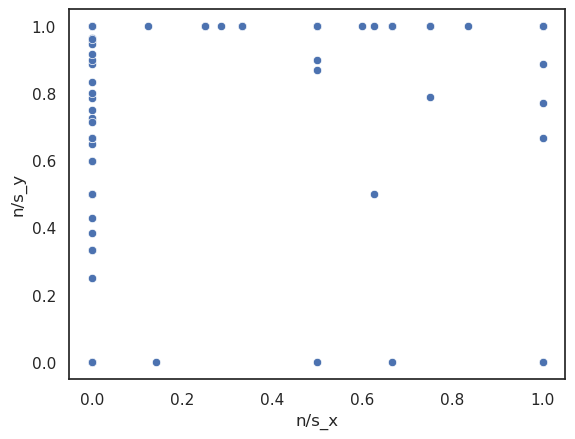

In [15]:
sns.scatterplot(data=o_div, x="n/s_x", y="n/s_y")